In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [40]:
#df = pd.read_csv('GJ-486b-spectra.csv')
df = pd.read_csv('table_K2-18-b-Tsiaras-et-al.-2019.csv')
#df = pd.read_csv('table_HAT-P-18-b-Fu-et-al.-2022.csv')
#df = pd.read_csv('table_HAT-P-11-b-Fraine-et-al.-2014.csv')
#df = pd.read_csv('table_HD-209458-b-Sing-et-al.-2016.csv')

#df = pd.read_csv('table_GJ-3470-b-Ehrenreich-et-al.-2014.csv')

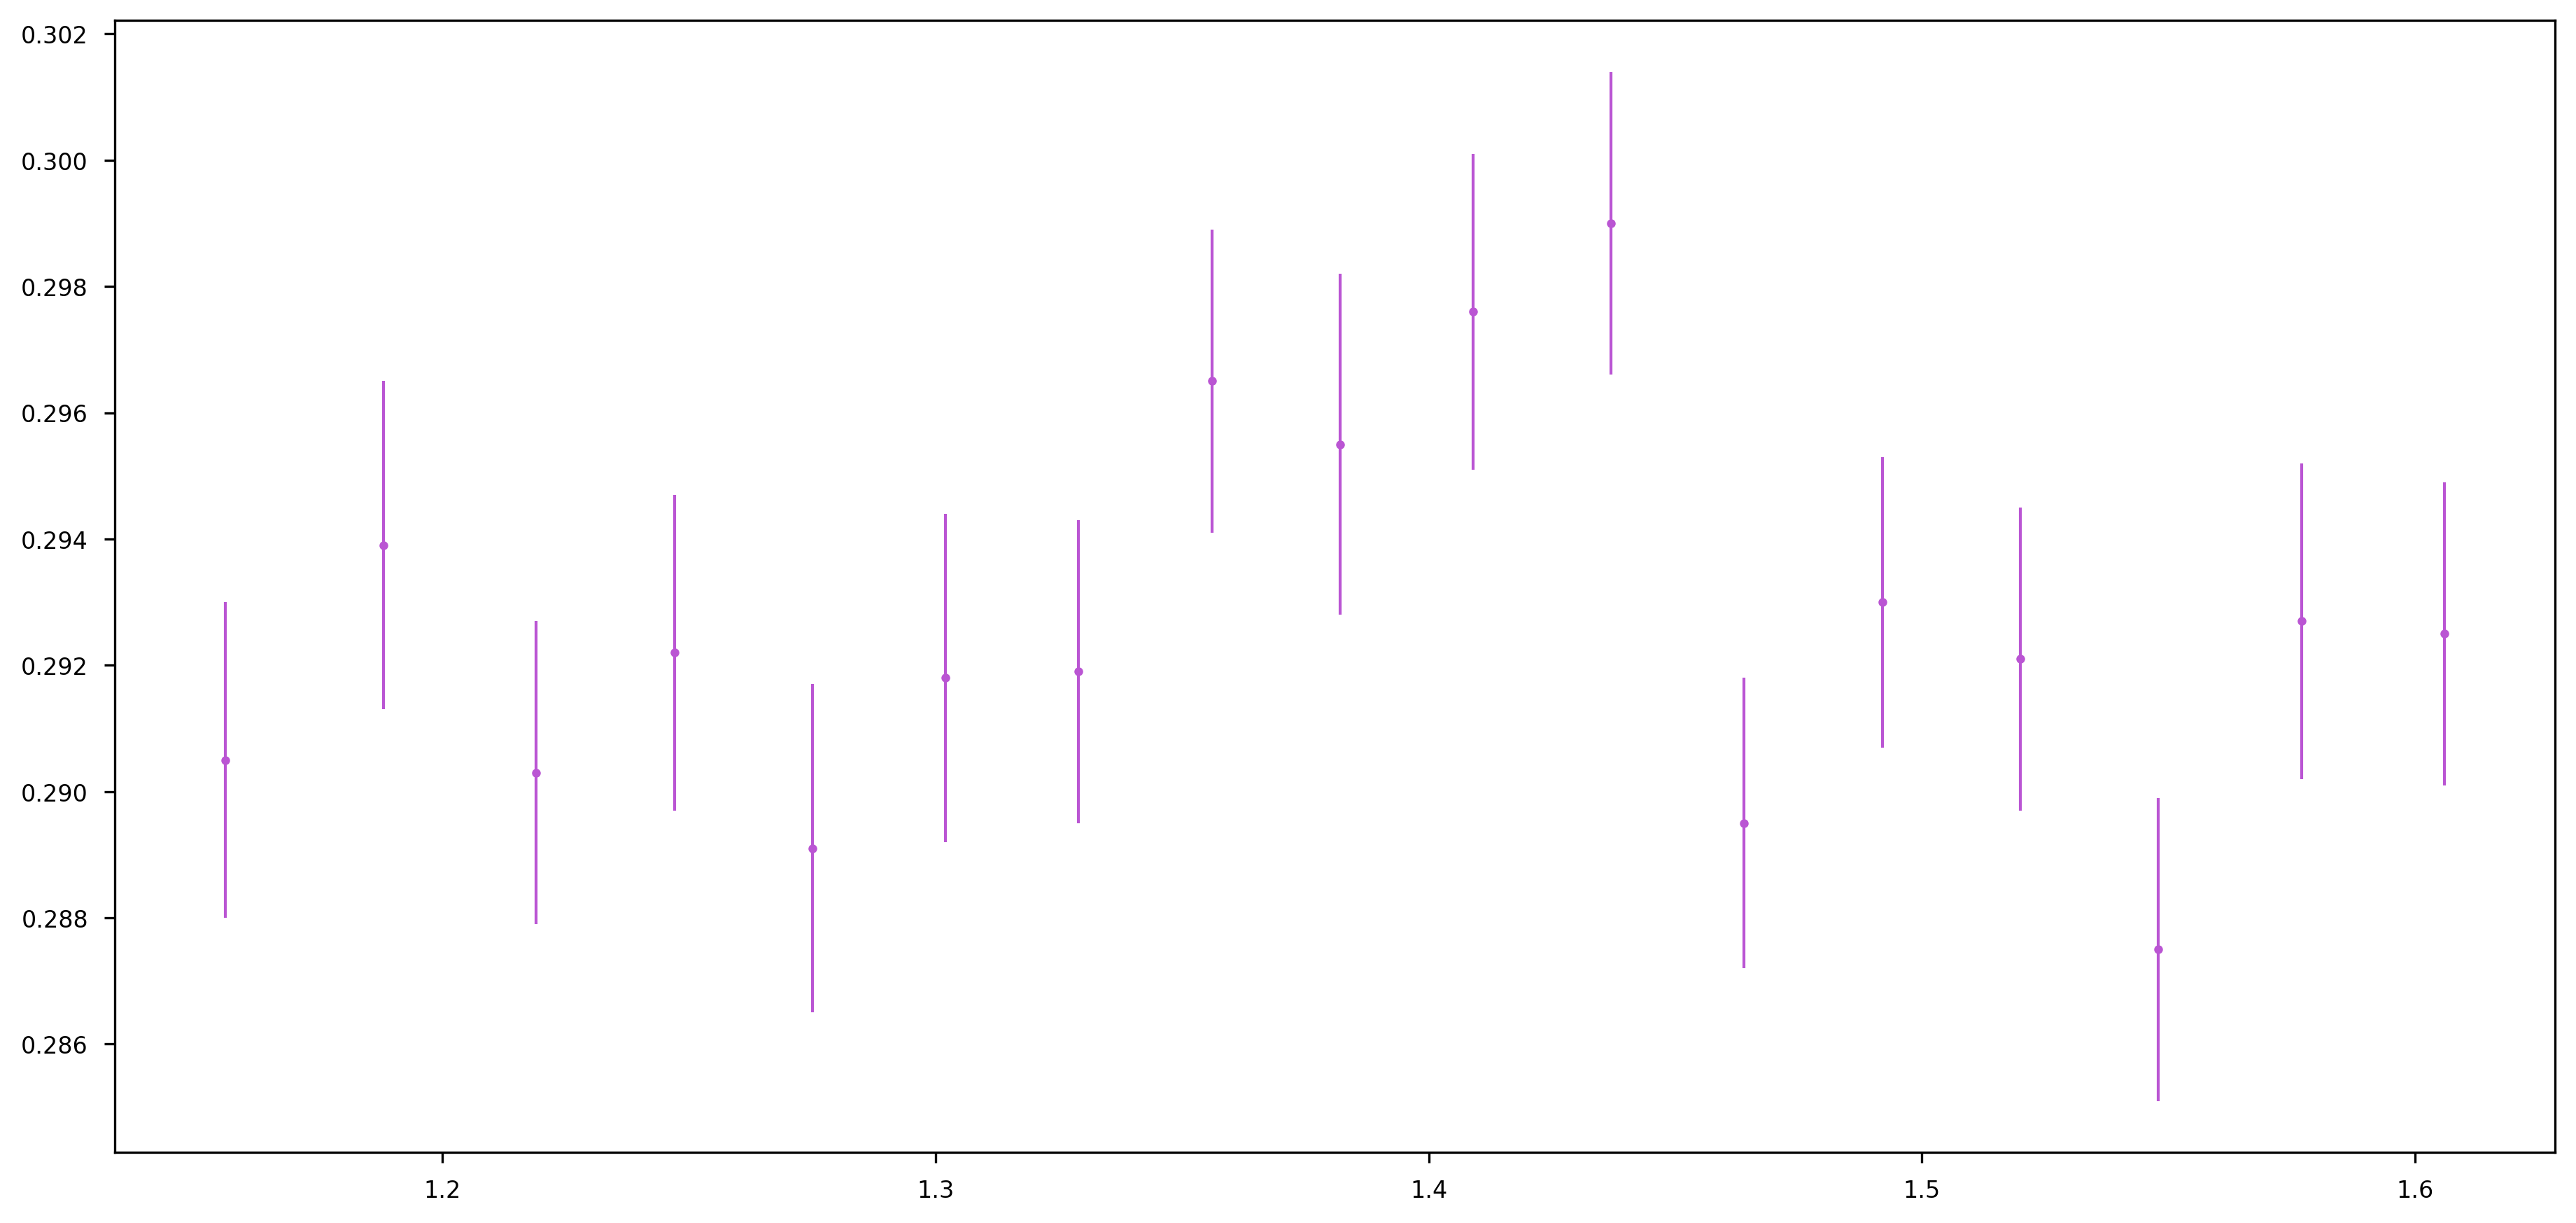

In [41]:
plt.figure(figsize=(15,7))
plt.errorbar(df['CENTRALWAVELNG'], df['PL_TRANDEP'], yerr = df['PL_TRANDEPERR1'], color = 'mediumorchid', fmt='o')
plt.show()

In [6]:
import os
os.environ['picaso_refdata'] = 'reference'
os.environ['PYSYN_CDBS'] = 'grp/redcat/trds/'

import picaso.justdoit as jdi
import picaso.justplotit as jpi
import picaso.analyze as lyz


In [42]:
model_dir = 'Models'
grid_name = "picaso_cldy"
location = os.path.join(model_dir,"RCTE_cloudy")
fitter = lyz.GridFitter(grid_name,location, verbose=True)

Total number of models in grid is 3840
For tint in planet_params grid is: [100. 200. 300.]
For heat_redis in planet_params grid is: [0.4 0.5]
For logkzz in planet_params grid is: [ 5.  7.  9. 11.]
For mh in planet_params grid is: [  0.1     0.316   1.      3.162  10.     31.623  50.119 100.   ]
For cto in planet_params grid is: [0.229 0.458 0.687 0.916]
For fsed in cld_params grid is: [ 0.6  1.   3.   6.  10. ]


In [43]:
wlgrid_center, wlgrid_width, rprs_data2, e_rprs2 = np.array(df['CENTRALWAVELNG']), np.array(df['BANDWIDTH']), np.array(df['PL_TRANDEP'])/100, np.array(df['PL_TRANDEPERR1'])/100


#wlgrid_center,rprs_data2,wlgrid_width, e_rprs2 = np.loadtxt('FIREFLY_REDUCTION.txt',usecols=[0,1,2,3],unpack=True,skiprows=1)
fitter.add_data('fabcd',wlgrid_center, wlgrid_width, rprs_data2, e_rprs2)

In [44]:
fitter.fit_grid('picaso_cldy','fabcd')

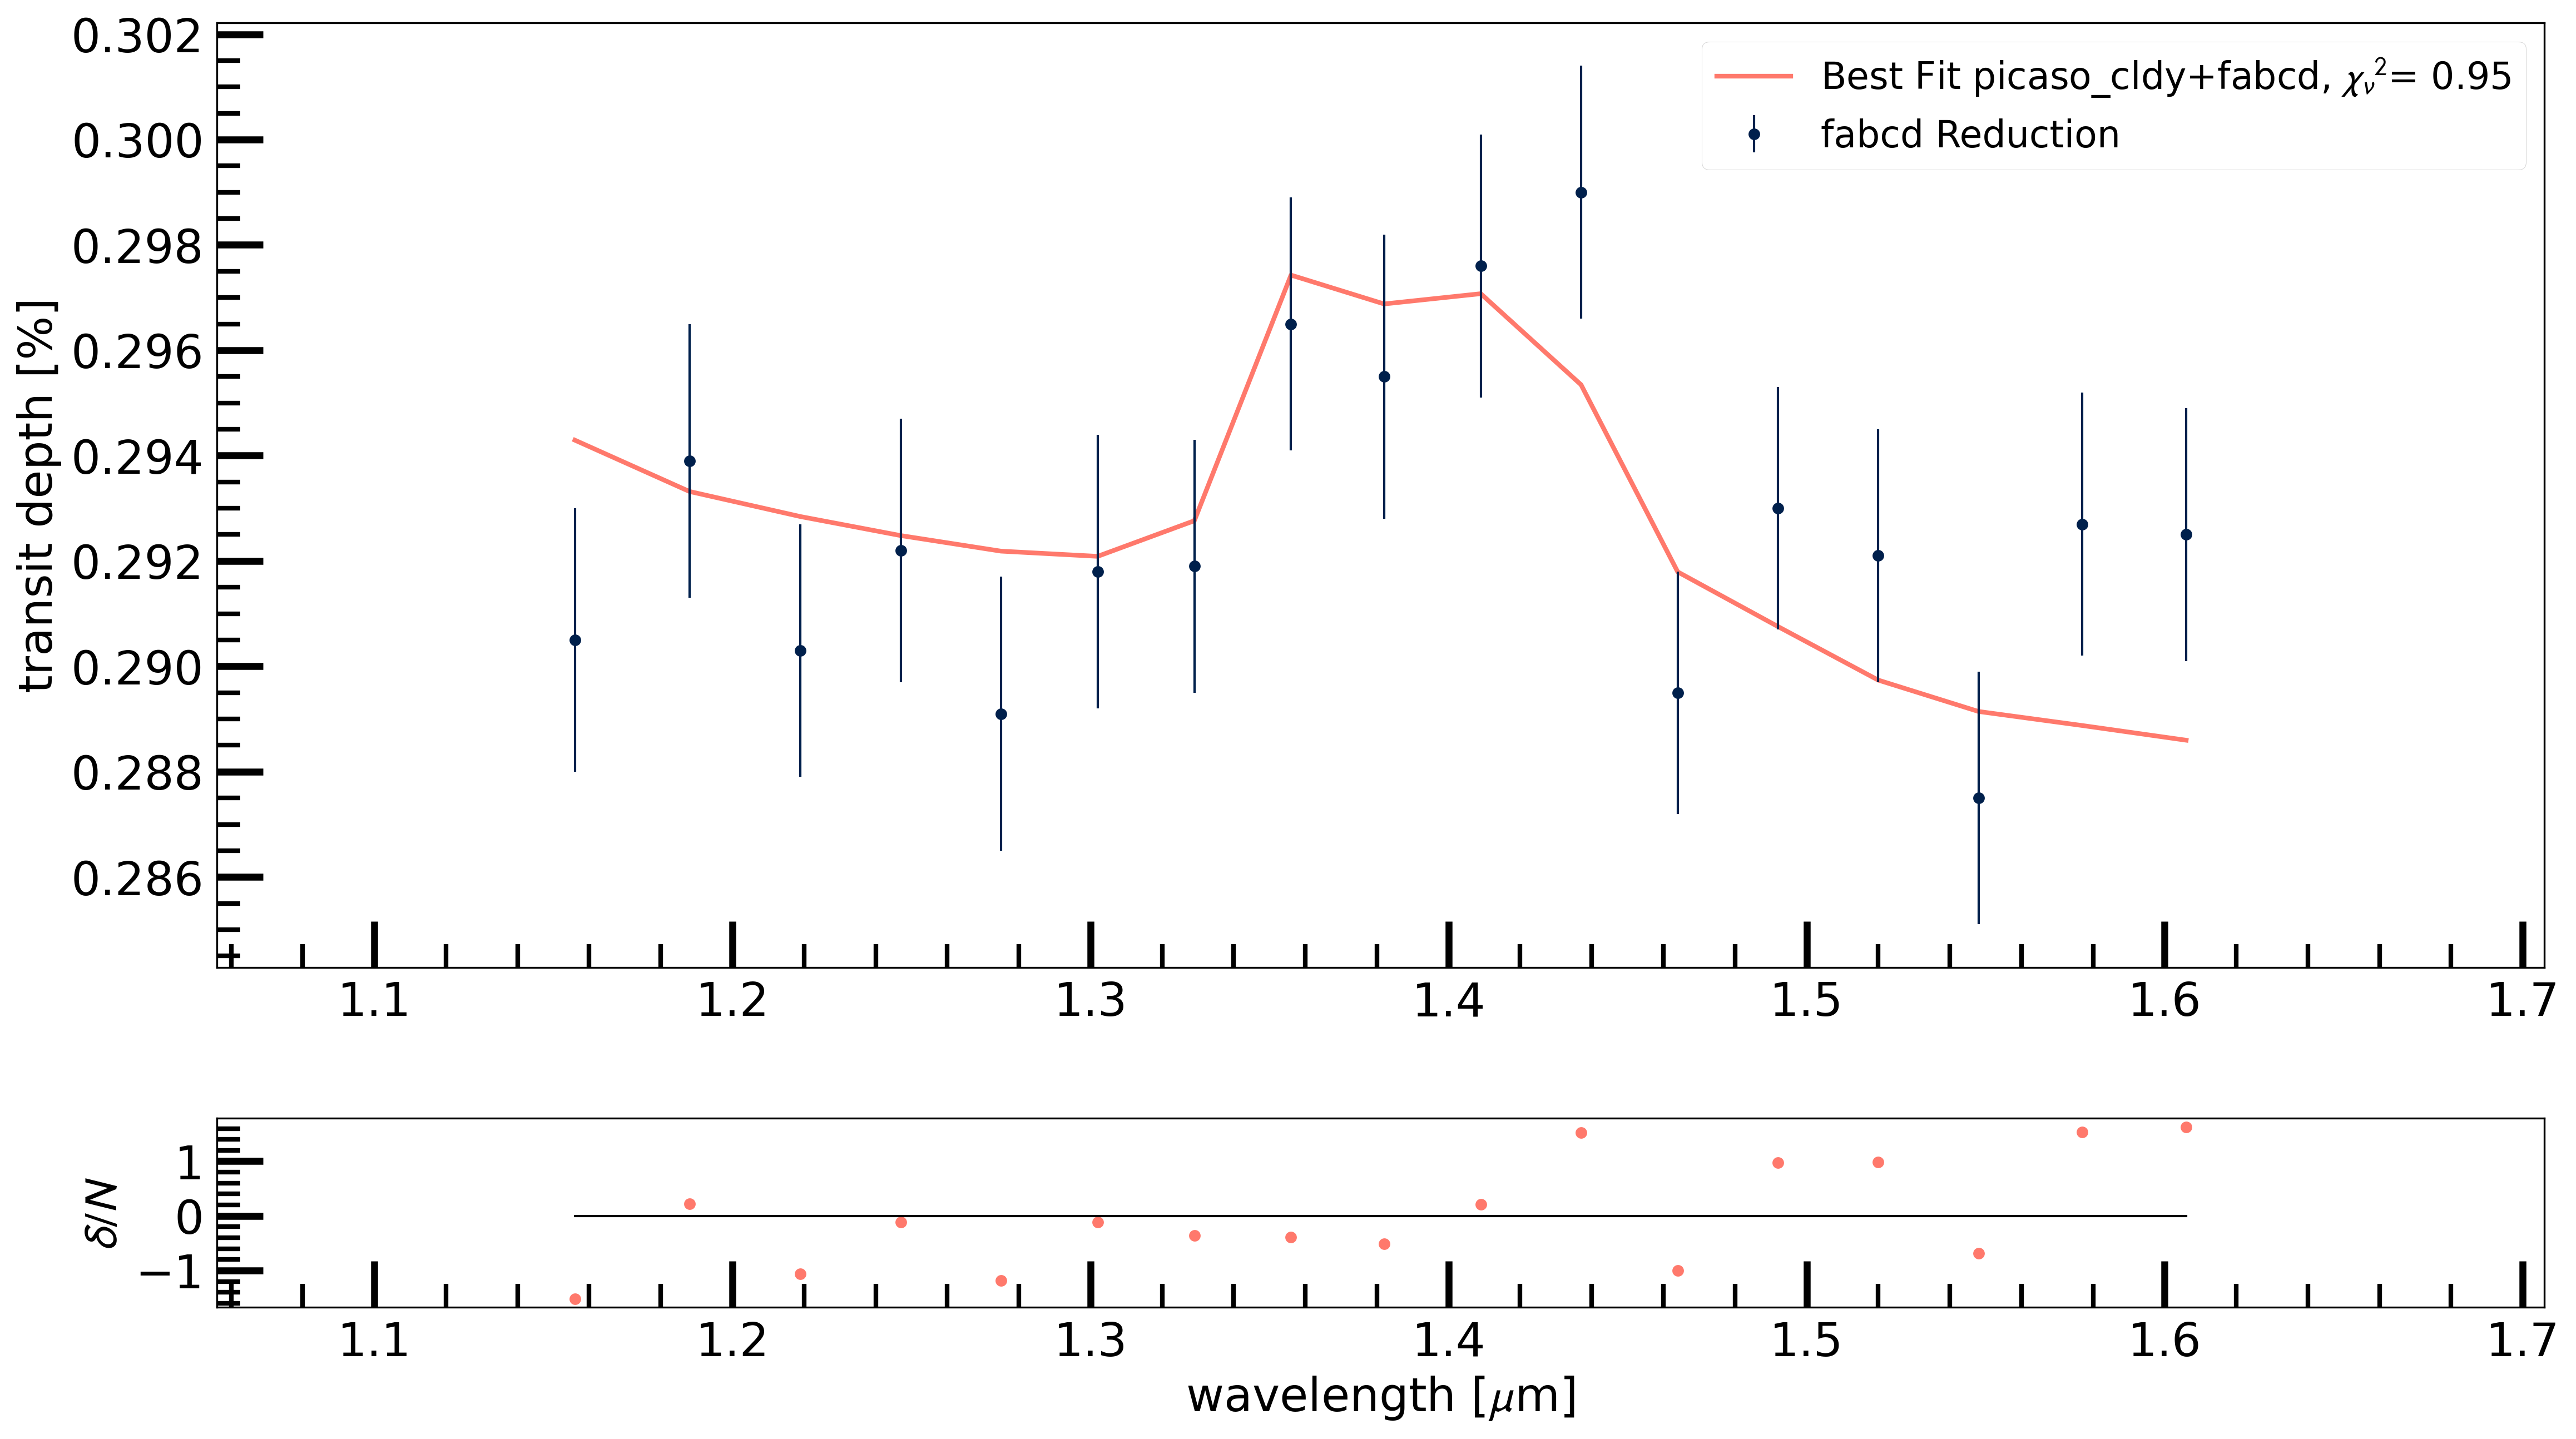

In [45]:
fig,ax = fitter.plot_best_fit(['picaso_cldy'],'fabcd')

In [46]:
out = fitter.as_dict()
print("cld free", np.array(out['chi_sqs']['picaso_cldy']['fabcd']
        )[out['rank_order']['picaso_cldy']['fabcd']][0:5])

cld free [0.95176934 0.95244363 0.95657694 1.0352134  1.04016512]


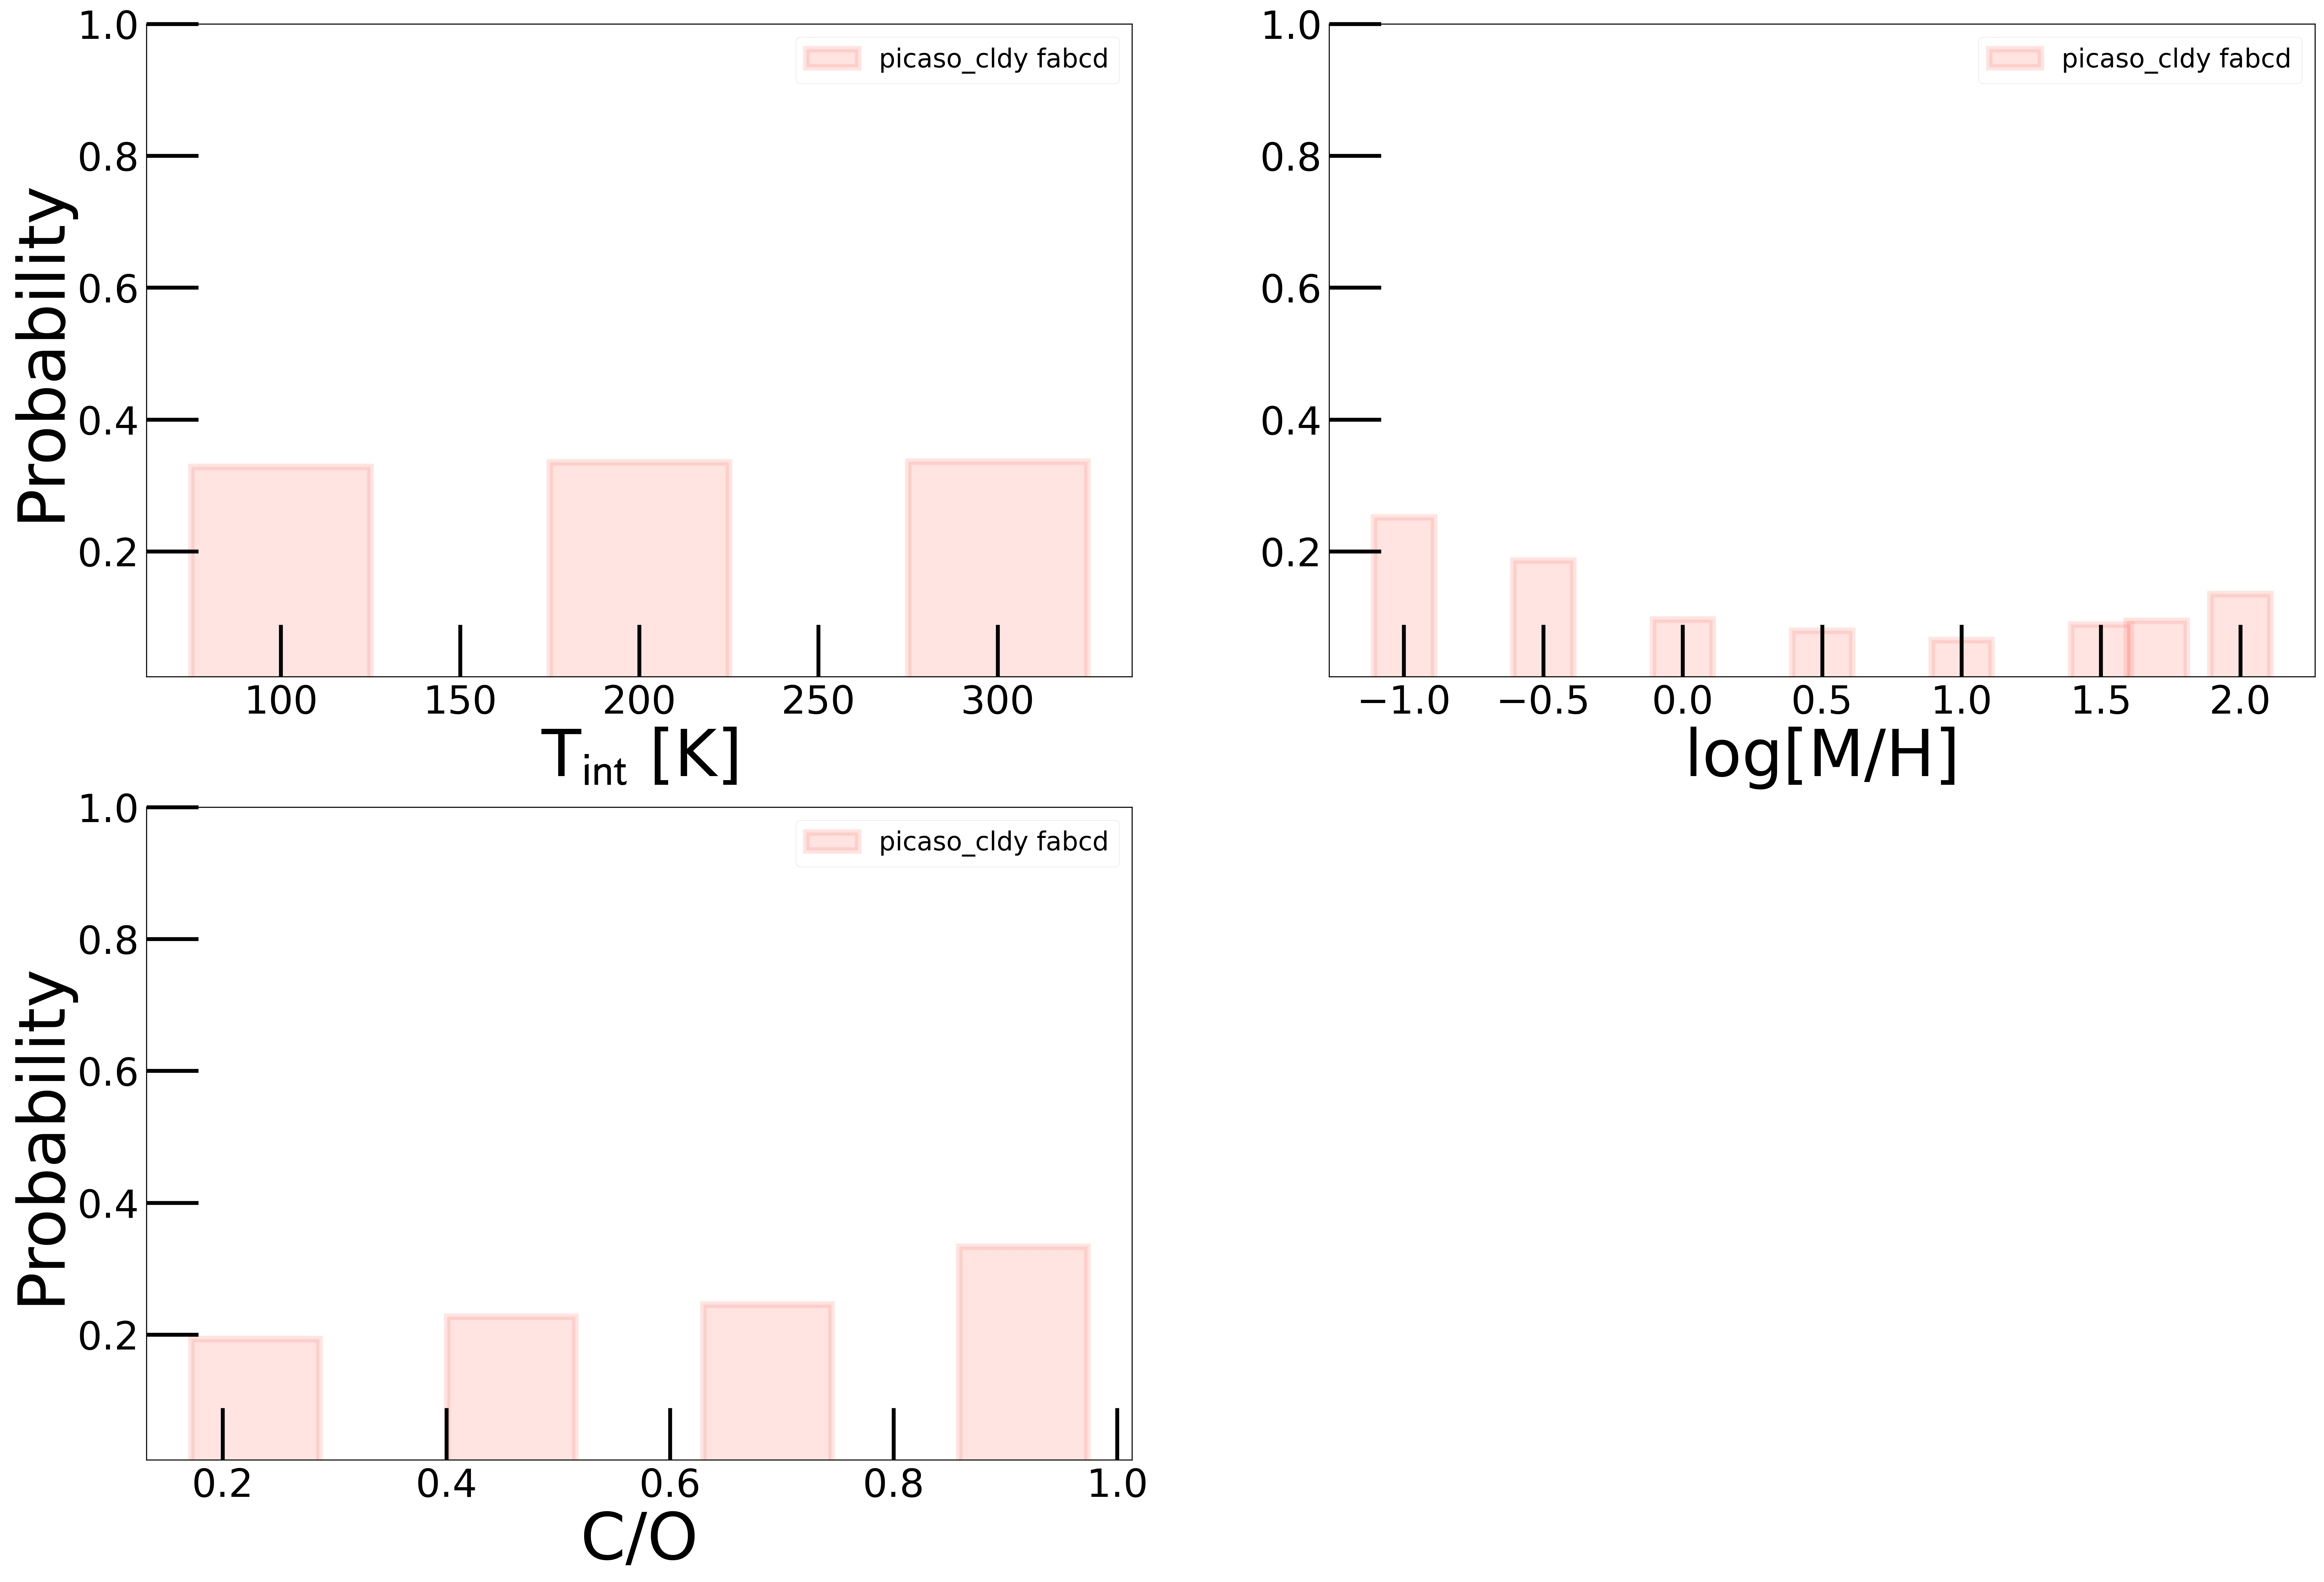

In [47]:
f,a=fitter.plot_posteriors('picaso_cldy','fabcd',['tint','mh','cto'],
               x_label_style={'tint':r"T$_{\rm int}$ [K]",
                              'mh':"log[M/H]", 'cto':r"C/O"},
               x_axis_type={'tint':r"linear",
                              'mh':"log", 'cto':r"linear"})

In [48]:
top_model_file  = np.array(out['list_of_files']['picaso_cldy']
        )[out['rank_order']['picaso_cldy']['fabcd']][0]

xr_usr = jdi.xr.load_dataset(top_model_file)
#take a look at the Xarray file
xr_usr

<xarray.Dataset>
Dimensions:                         (pressure: 91, wavelength: 8988,
                                     pressure_cld: 90, wno_cld: 196)
Coordinates:
  * pressure                        (pressure) float64 1e-06 1.249e-06 ... 500.0
  * wavelength                      (wavelength) float64 6.0 5.998 ... 0.3001
  * pressure_cld                    (pressure_cld) float64 1.118e-06 ... 180.9
  * wno_cld                         (wno_cld) float64 43.95 72.05 ... 3.731e+04
Data variables: (12/54)
    opd                             (pressure_cld, wno_cld) float64 9.717e-10...
    ssa                             (pressure_cld, wno_cld) float64 1.229e-09...
    asy                             (pressure_cld, wno_cld) float64 1.995e-14...
    condensate_mmr_Na2S             (pressure_cld) float64 1.5e-06 ... 0.0
    condensate_plus_gas_mmr_Na2S    (pressure_cld) float64 5.657e-06 ... 0.00...
    mean_particle_r_Na2S            (pressure_cld) float64 0.0009878 ... 0.0
    ...                              ...
    OCS                             (pressure) float64 9.399e-11 ... 5.556e-11
    Li                              (pressure) float64 6.75e-15 ... 7.49e-10
    LiOH                            (pressure) float64 5.773e-12 ... 2.321e-11
    LiH                             (pressure) float64 4.146e-18 ... 4.956e-10
    LiCl                            (pressure) float64 2.21e-10 ... 5.081e-13
    transit_depth                   (wavelength) float64 0.02463 ... 0.02556
Attributes:
    author:          Sarah E. Moran
    contact:         semoran@lpl.arizona.edu
    code:            {"spectrum": "PICASO", "climate": "PICASO", "chemistry":...
    doi:             Mukherjee et al., submitted; Batalha et al., in prep
    planet_params:   {"rp": {"value": 1.279, "unit": "jupiterRad"}, "mp": {"v...
    stellar_params:  {"rs": {"value": 0.932, "unit": "solRad"}, "logg": 4.389...
    orbit_params:    {"sma": 0.0486}
    atmo_params:     {"mh": -0.5, "cto": 1.0}
    cld_params:      {"fsed": 1.0, "species": "Na2S, MnS, MgSiO3"}

In [49]:
min_wave = 1.2 #min wave to search for gauss peak
max_wave = 1.6 #max wave to search for gauss peak

opa = jdi.opannection(wave_range=[min_wave,max_wave])
case = jdi.input_xarray(xr_usr, opa)

In [50]:
og_atmo = jdi.copy.deepcopy(case.inputs['atmosphere']['profile'])
#atmo
w,f,l =[],[],[]
for iex in ['CH4','H2O','CO2',None]:
    case.atmosphere(df = og_atmo,exclude_mol=iex, delim_whitespace=True)
    df= case.spectrum(opa, full_output=True,calculation='transmission') #note the new last key
    wno, rprs2  = df['wavenumber'] , df['transit_depth']
    wno, rprs2 = jdi.mean_regrid(wno, rprs2, R=150)
    w +=[wno]
    f+=[rprs2]
    if iex==None:
        leg='all'
    else:
        leg = f'No {iex}'
    l+=[leg]
#jpi.show(jpi.spectrum(w,f,legend=l))

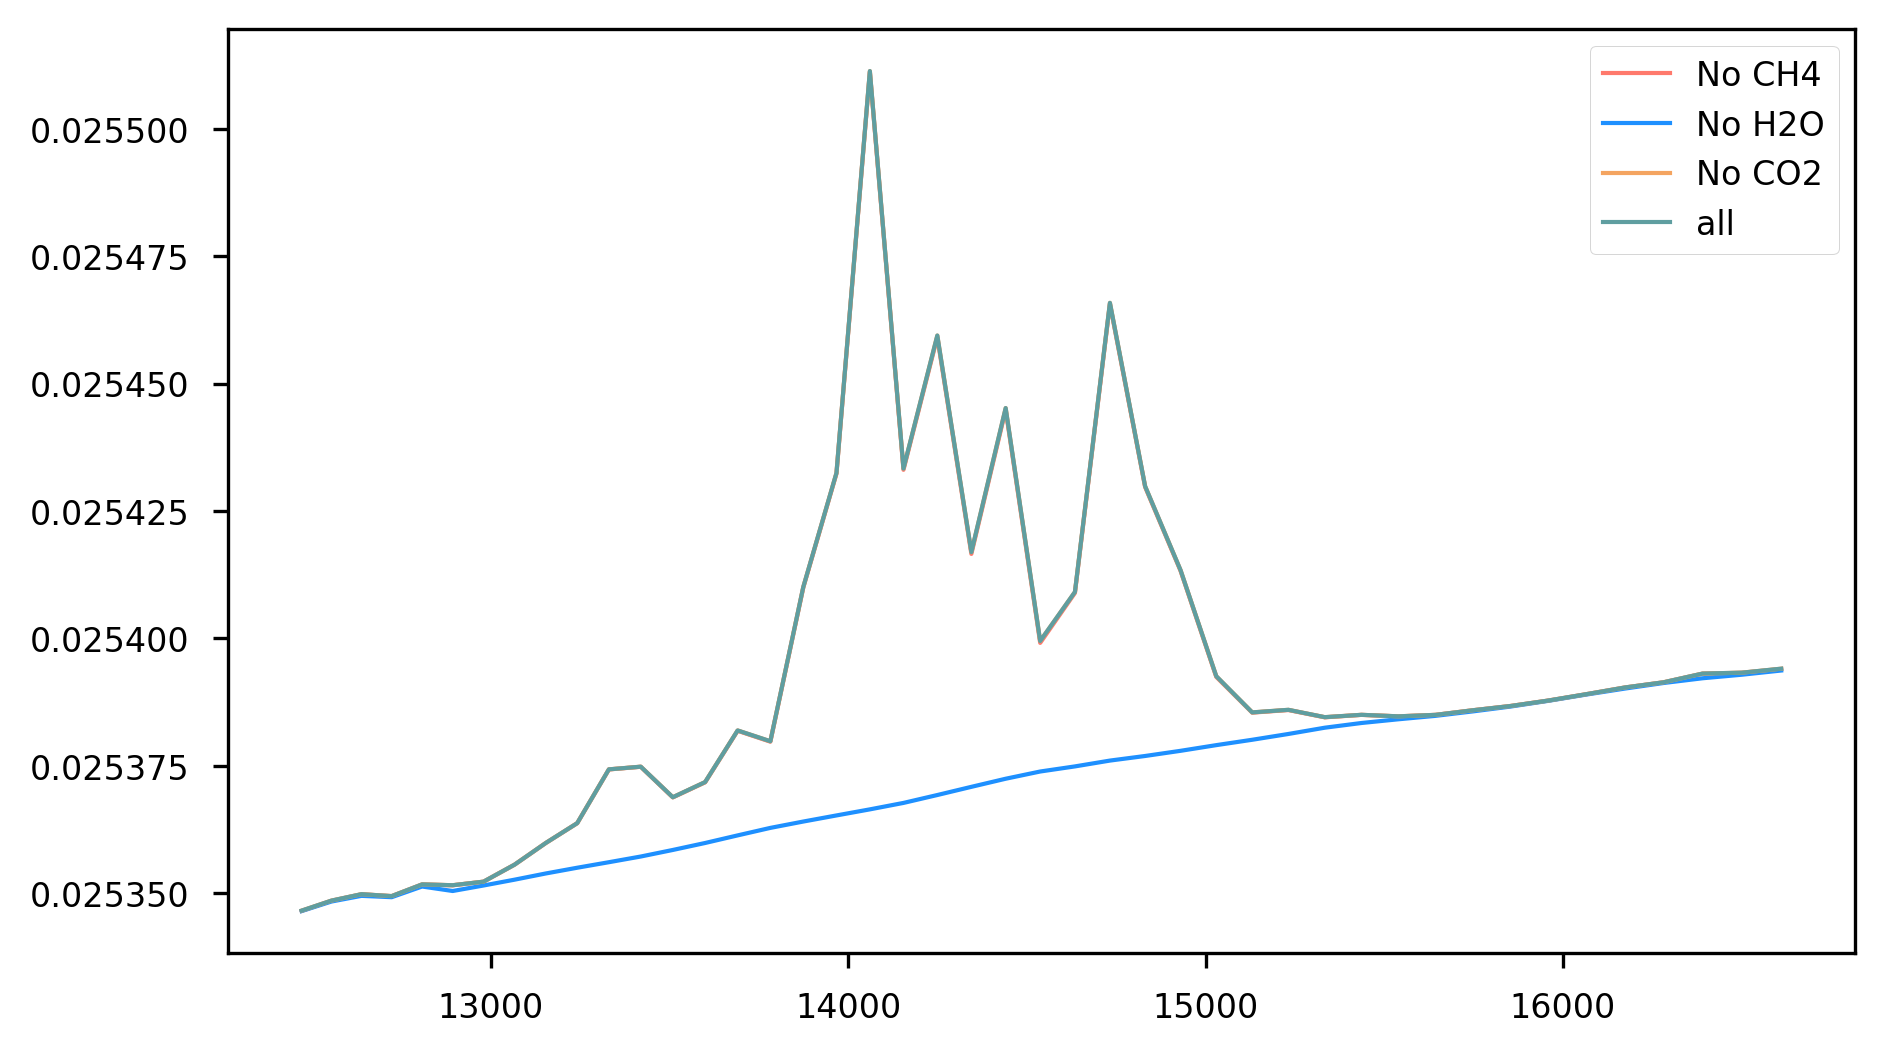

In [51]:
for i in range(len(w)):
    plt.plot(2*w[i],f[i],label=l[i])
    
plt.legend()
plt.show()

5533it [00:10, 533.16it/s, +500 | bound: 13 | nc: 1 | ncall: 27188 | eff(%): 22.606 | loglstar:   -inf < -849.627 <    inf | logz: -859.947 +/-  0.140 | dlogz:  0.001 >  0.509]
5066it [00:09, 524.79it/s, +500 | bound: 8 | nc: 1 | ncall: 23085 | eff(%): 24.645 | loglstar:   -inf < -849.593 <    inf | logz: -858.872 +/-  0.128 | dlogz:  0.001 >  0.509]


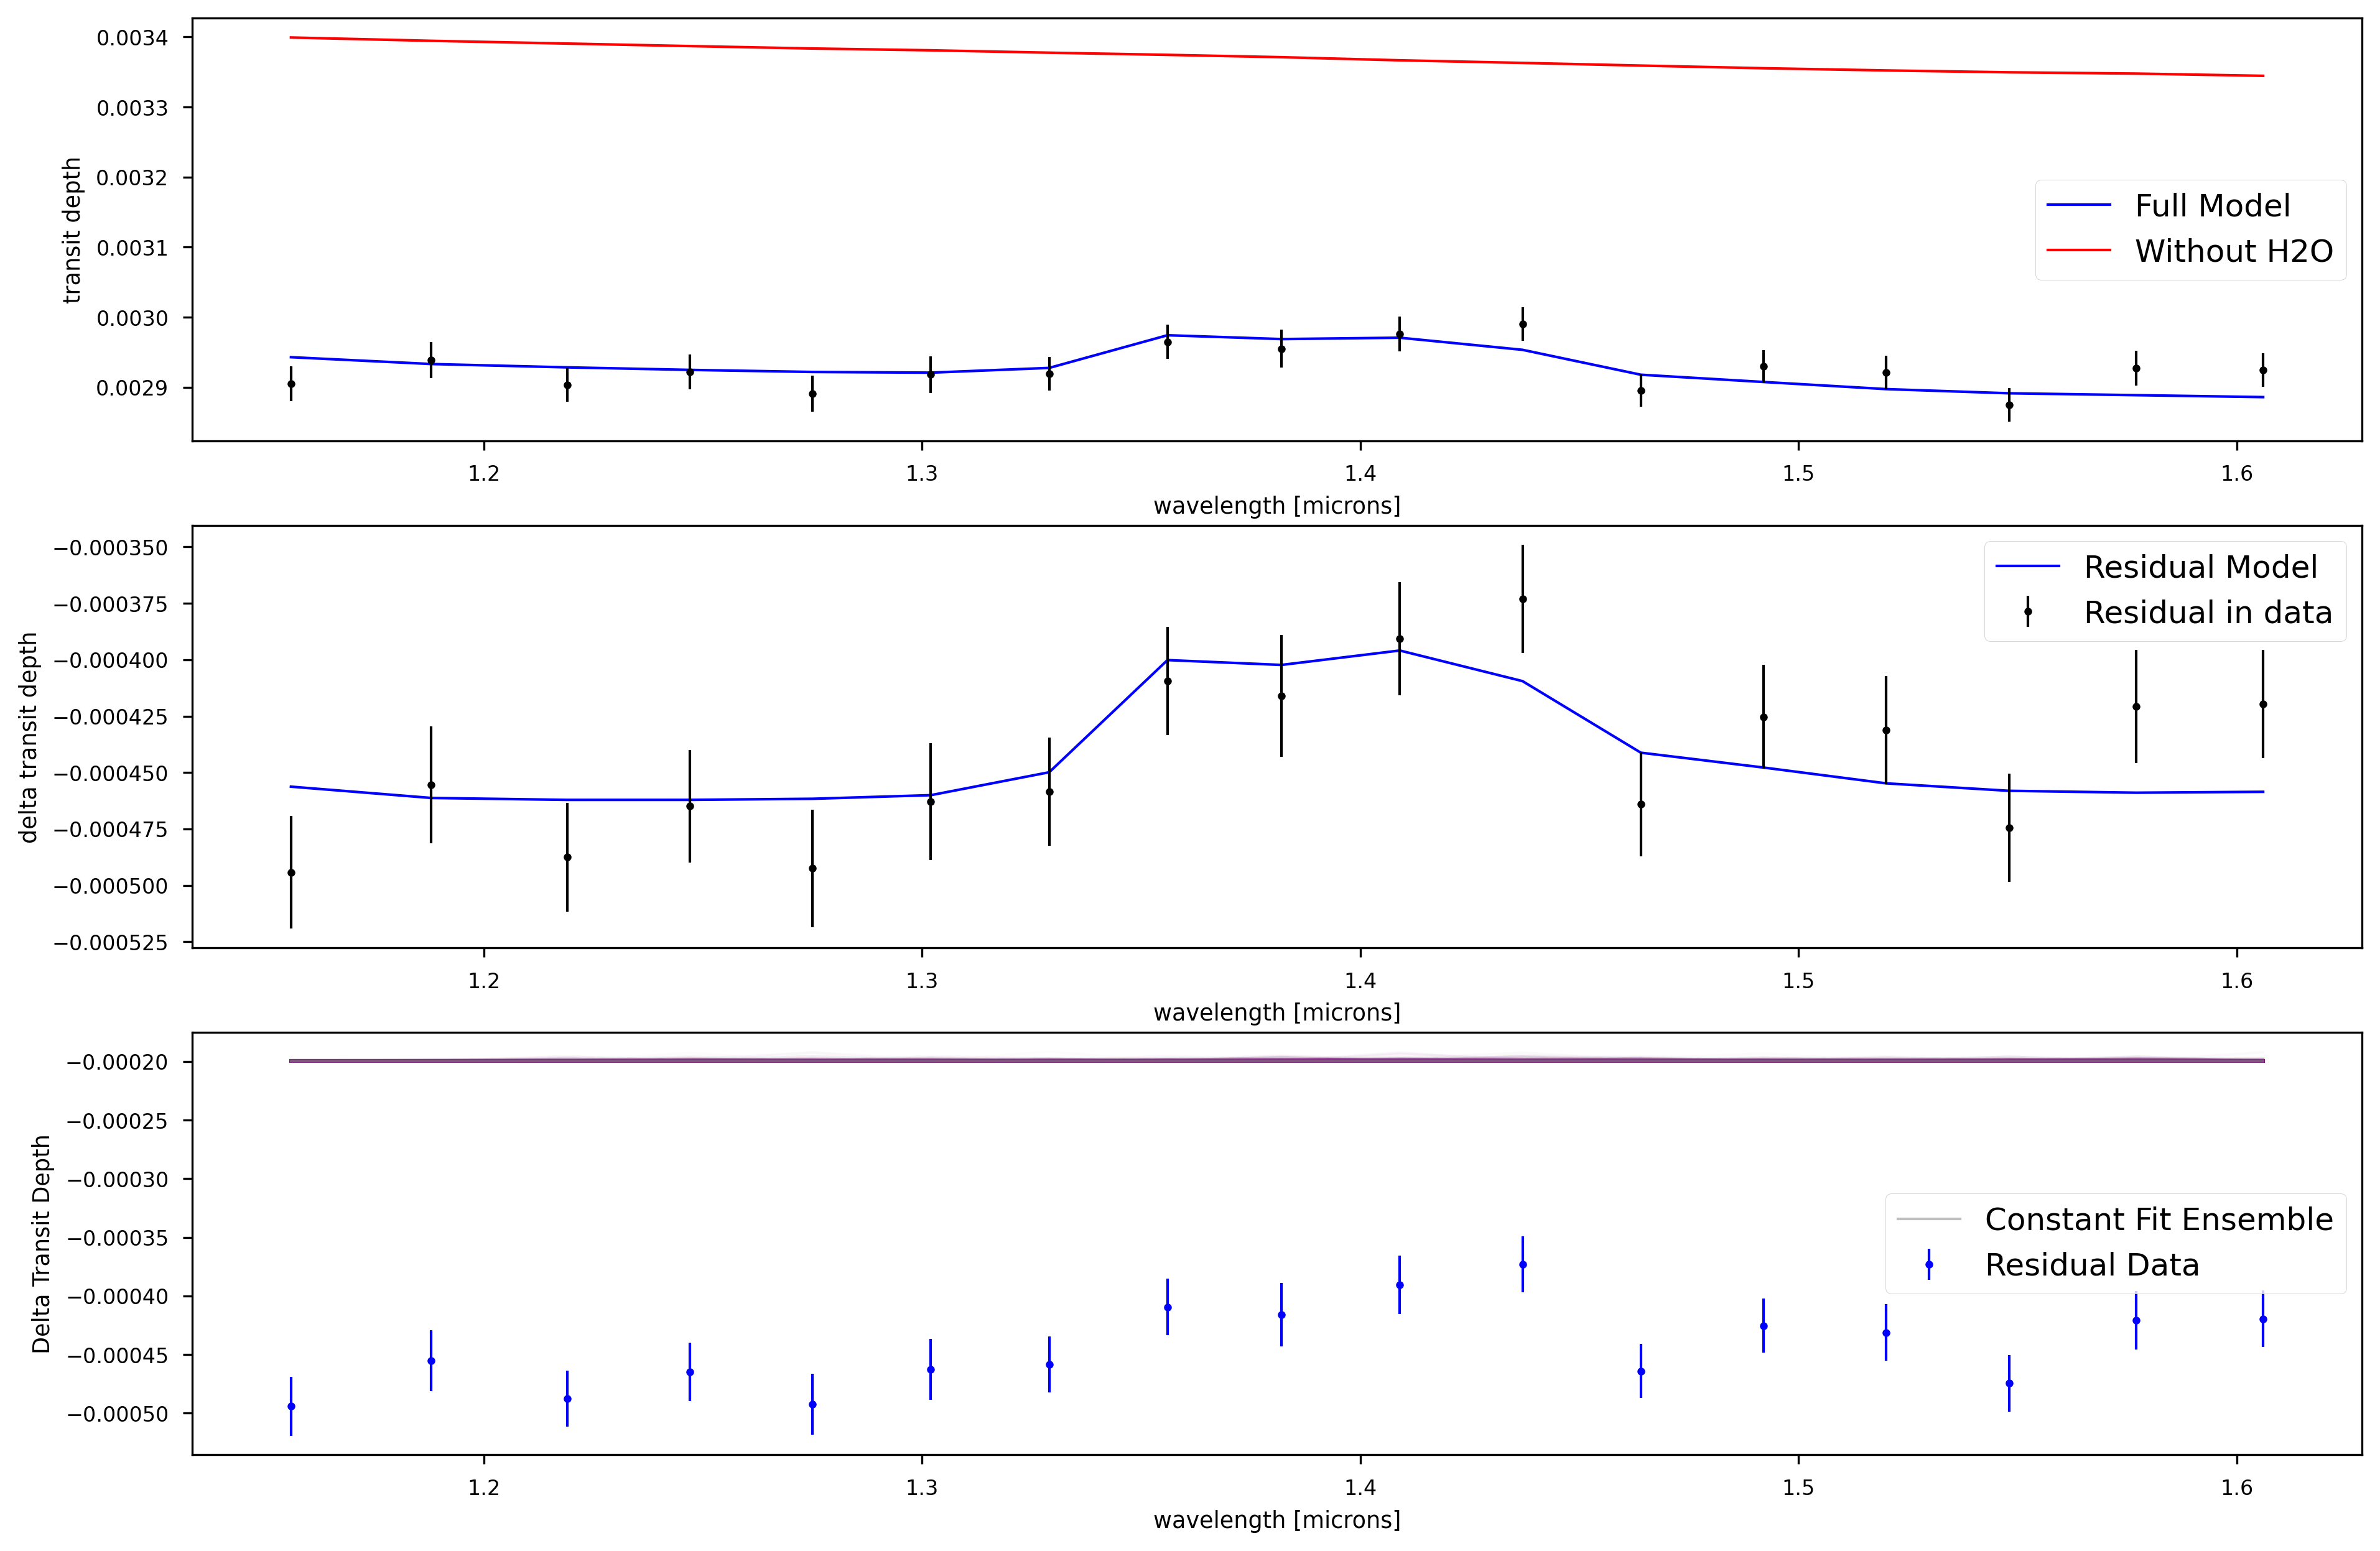

In [52]:


out = lyz.detection_test(fitter,'H2O',min_wave,max_wave,'picaso_cldy','fabcd',
                     top_model_file,
                     #opa_kwargs={wave_range=[]}#this is where you input arguments for opannection
                     plot=True)

In [53]:
out['sigma_single_v_line']

0.260695187067725

5646it [00:09, 568.53it/s, +500 | bound: 14 | nc: 1 | ncall: 28973 | eff(%): 21.585 | loglstar:   -inf < -979.653 <    inf | logz: -990.181 +/-  0.142 | dlogz:  0.001 >  0.509]
5231it [00:09, 550.24it/s, +500 | bound: 8 | nc: 1 | ncall: 23494 | eff(%): 24.924 | loglstar:   -inf < -979.538 <    inf | logz: -989.153 +/-  0.132 | dlogz:  0.001 >  0.509]


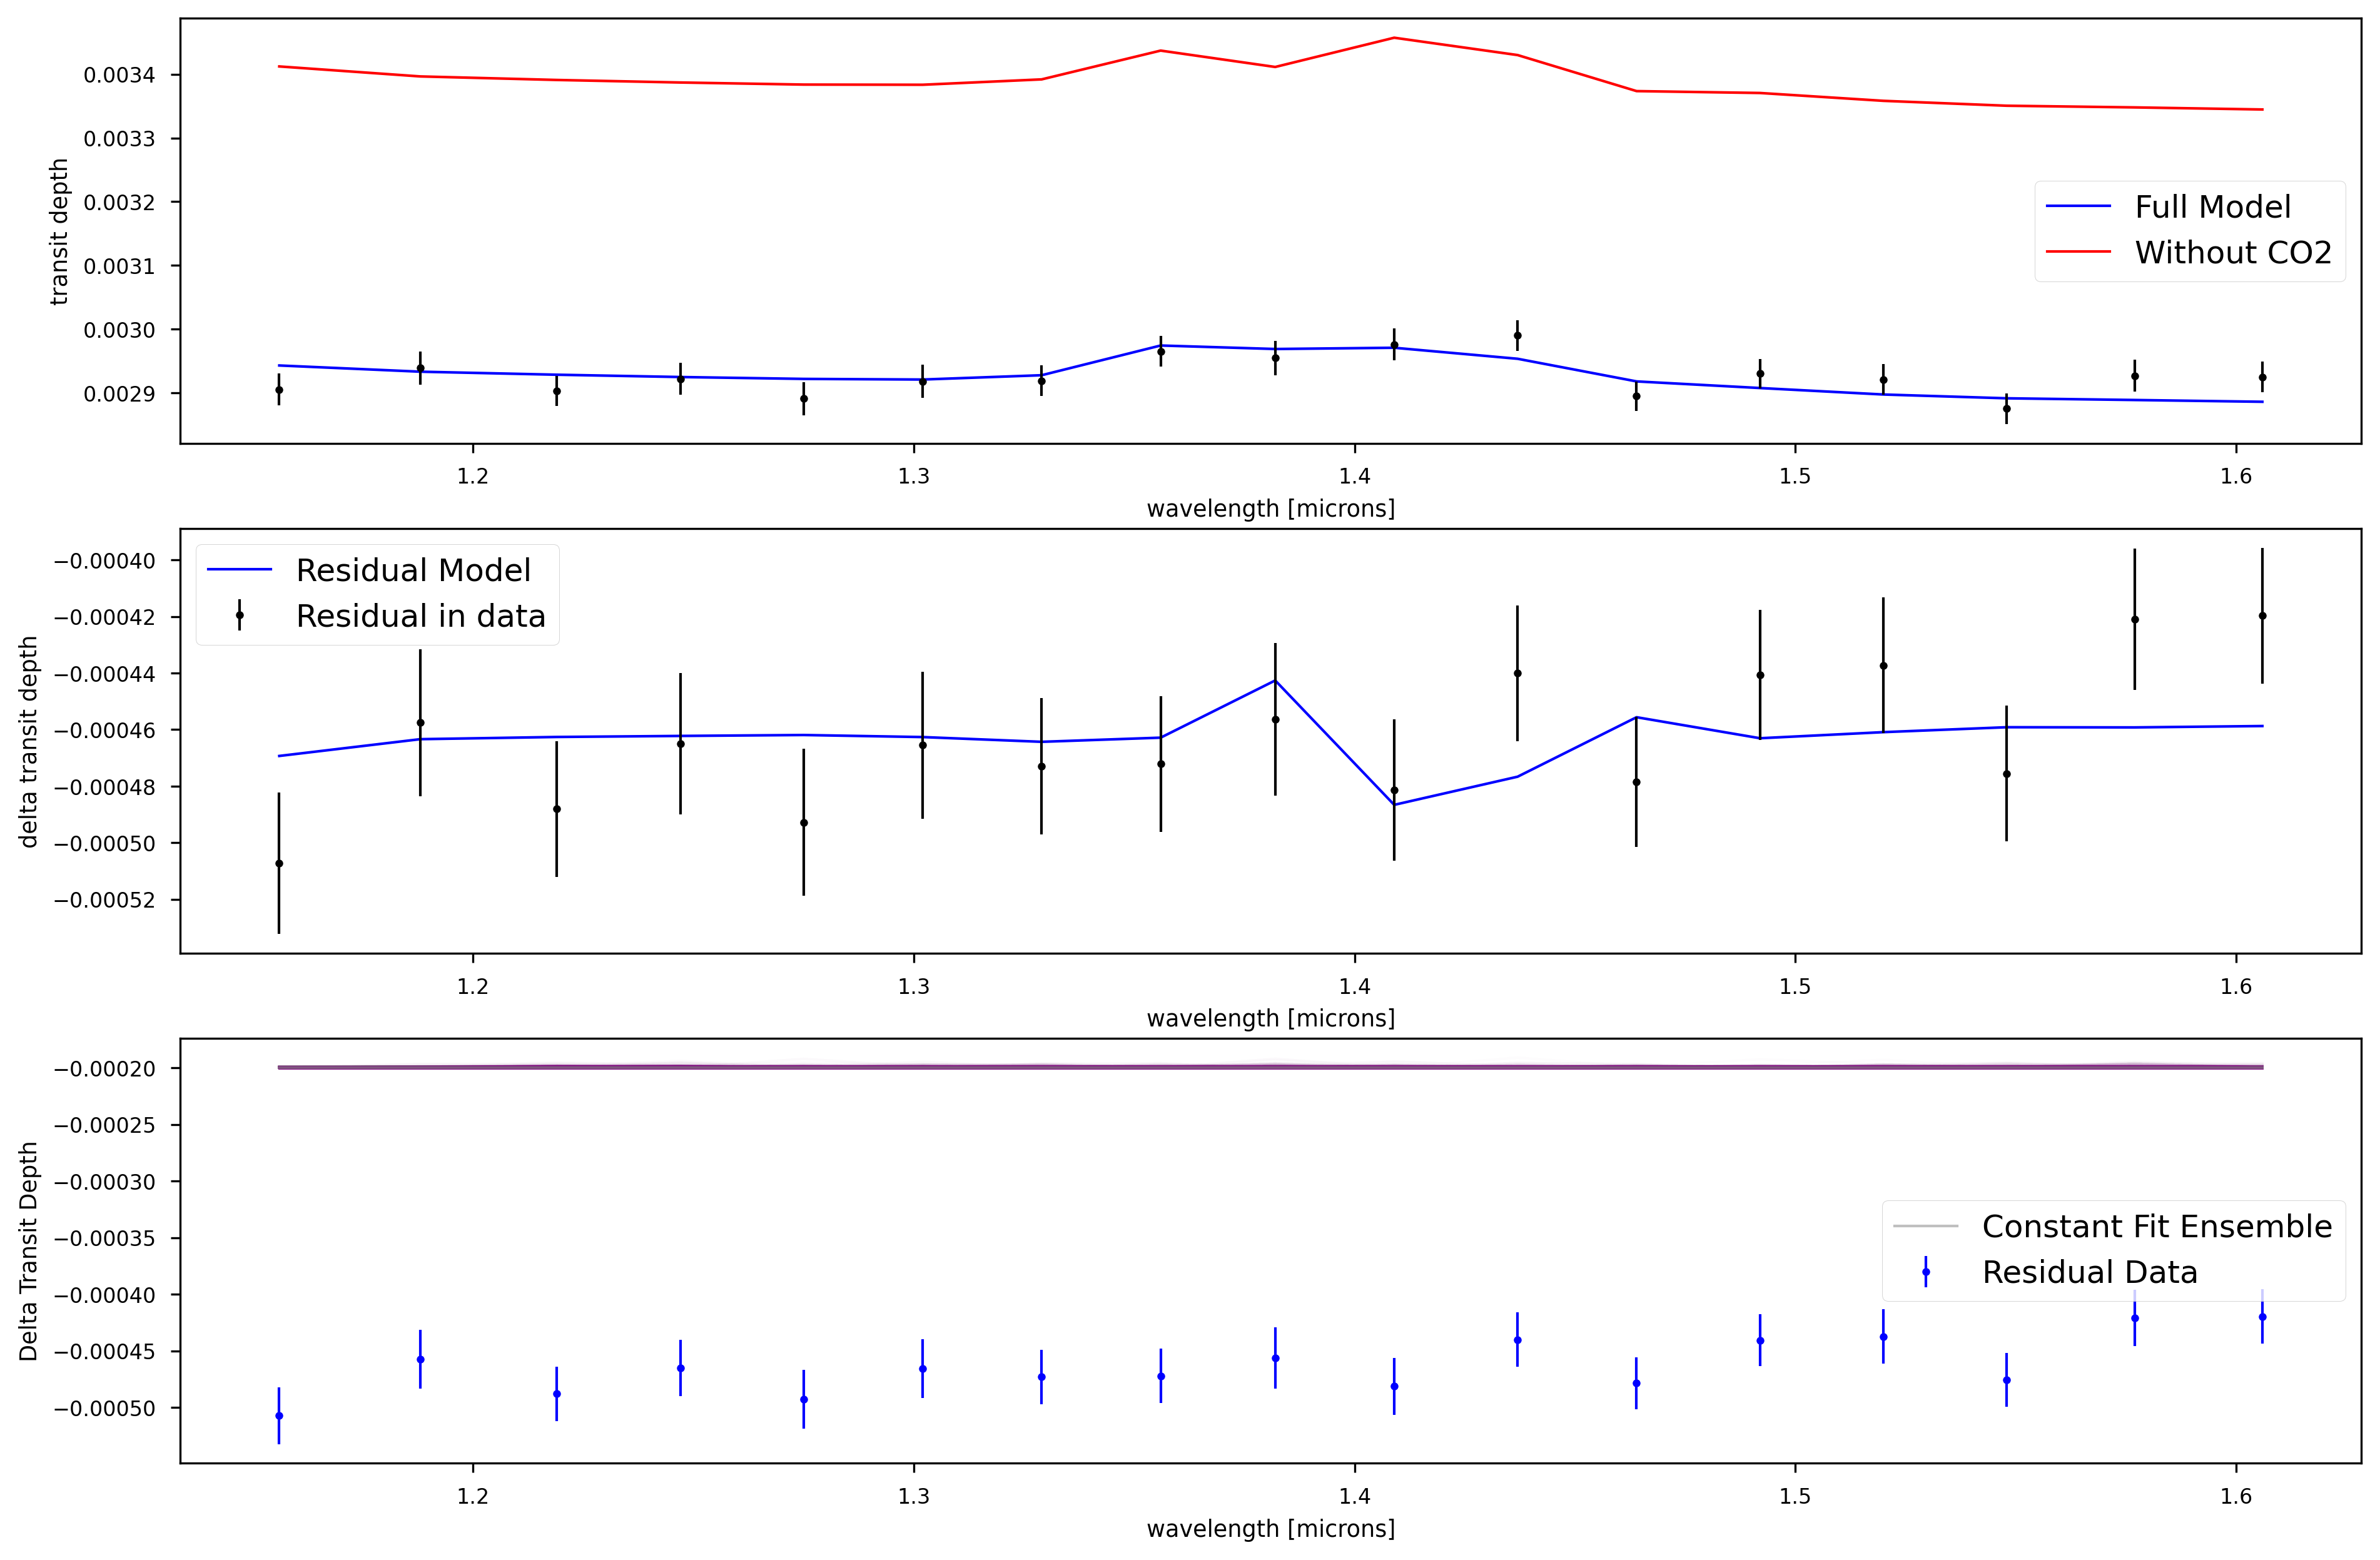

In [54]:

out = lyz.detection_test(fitter,'CO2',min_wave,max_wave,'picaso_cldy','fabcd',
                     top_model_file,
                     #opa_kwargs={wave_range=[]}#this is where you input arguments for opannection
                     plot=True)

In [55]:
out['sigma_single_v_line']

0.260695187067725